In [1]:
#------ manually fix import for now
import sys
sys.path.append('..')
#------

import numpy as np
import astropy.units as u
import astropy.constants as const
import emcee
from redexo import *
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import copy
import corner

Loading 44 files...


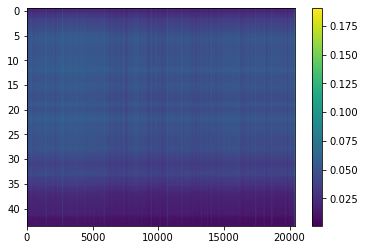

In [2]:
dataset = load_carmenes_data(folder='/users/ricolandman/Documents/Research/OH_exoplanets/Data/Wasp76_NIR/',\
                            spectral_orders=[23,24,25,26,27])

plt.imshow(dataset.spec.reshape(dataset.num_exposures,-1),aspect='auto')
plt.colorbar()
plt.show()

In [3]:
planet = Planet(Kp=196, vsys=-1.1, T0=2458080.626165, orbital_period=1.809886)
planet.transit_start = 0.045

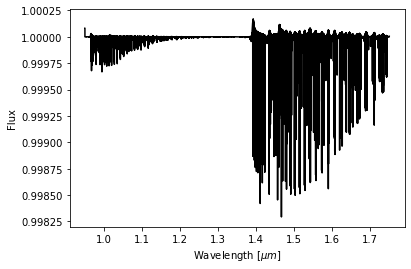

In [4]:
template_wl, template = np.load('/users/ricolandman/Documents/Research/OH_exoplanets/Data/models/Wasp76_OH_equilibrium_T=2150K_prepared.npy')
plt.plot(template_wl/1e4, template, color='black')
plt.xlabel(r'Wavelength [$\mu m$]')
plt.ylabel('Flux')
plt.show()

In [5]:
pipeline = Pipeline()

pipeline.add_module( FlagAbsorptionEmissionModule(flux_lower_limit=0.4, flux_upper_limit=1.1, 
                                                    relative_to_continuum=True) )
pipeline.add_module( PolynomialContinuumRemovalModule(poly_order=3))


pipeline.add_module( OutlierFlaggingModule(sigma=5) )

pipeline.add_module( SysRemModule(number_of_modes=9, mode='subtract', name='cleaned') )

In [6]:
pipeline.run(dataset, num_workers=None, per_order=True)
pipeline.summary()

----------Summary--------
Running <redexo.modules.cleaning.FlagAbsorptionEmissionModule object at 0x153d2ba30> took 0.09 seconds
Running <redexo.modules.cleaning.PolynomialContinuumRemovalModule object at 0x153d2b520> took 0.06 seconds
Running <redexo.modules.cleaning.OutlierFlaggingModule object at 0x153d2bf10> took 0.01 seconds
Running <redexo.modules.telluric_correction.SysRemModule object at 0x153d2be50> took 0.53 seconds
--> Total time: 0.69 seconds
------------------------


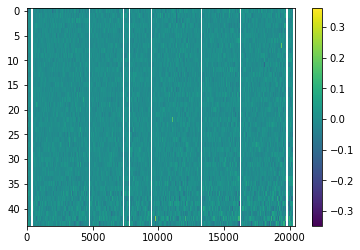

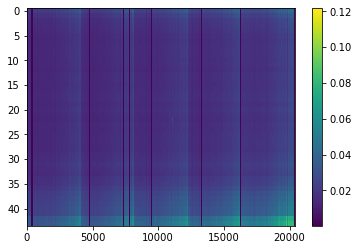

In [7]:
res = pipeline.get_results('cleaned')
wl = res.wavelengths
errors = res.errors
spec = res.spec

wl = wl.reshape(wl.shape[0],-1)
errors = errors.reshape(errors.shape[0],-1)
spec = spec.reshape(spec.shape[0],-1)

plt.imshow(spec, aspect='auto', interpolation='none')
plt.colorbar()
plt.figure()
plt.imshow(errors, aspect='auto', interpolation='none')
plt.colorbar()

In [8]:
def likelihood_gibson(template, data, errors=None):
    if not errors is None:
        chi2 = np.nansum((template-data)**2/errors**2)
    else:
        chi2 = np.nansum((template-data**2))
    '''
    #template -= np.mean(template)
    #data -= np.mean(data)
    R = np.mean(template*data)
    sf2 = np.mean(data**2)
    sg2 = np.std(template**2)
    logL = -template.size/2 *np.log(sf2 - 2*R +sg2)
    '''
    return -template.size/2*np.sum(np.log(chi2))


def likelihood_brogi_line(template, data):
    
    #template -= np.mean(template)
    #data -= np.mean(data)
    R = np.nanmean(template*data,axis=1)
    sf2 = np.nanmean(data**2,axis=1)
    sg2 = np.nanstd(template**2,axis=1)
    logL = -np.sum(template.size/2 *np.log(sf2 - 2*R +sg2))
    return logL

In [9]:
class LikelihoodEvaluator():
    def __init__(self, dataset, template_dict, target):
        self.dataset = dataset
        
        self.in_transit = target.in_transit(dataset.obstimes)
        wl_arr = dataset.wavelengths.reshape(dataset.num_exposures, -1)
        wl_arr = wl_arr[self.in_transit]
        flux_arr = dataset.spec.reshape(dataset.num_exposures, -1)
        flux_arr = flux_arr[self.in_transit]
        
        error_arr = dataset.errors.reshape(dataset.num_exposures, -1)
        error_arr = error_arr[self.in_transit]
        
        self.wls = np.array([wl_arr[i][~np.isnan(flux_arr[i])] for i in range(wl_arr.shape[0])])
        self.errors = np.array([error_arr[i][~np.isnan(flux_arr[i])] for i in range(error_arr.shape[0])])
        self.fluxes = np.array([flux_arr[i][~np.isnan(flux_arr[i])] for i in range(flux_arr.shape[0])])
        self.template_dict = template_dict
        modelWave, modelTrans = self.template_dict['2200']
        model_res = np.median(modelWave[:-1]/np.diff(modelWave))
        self.model_dv = const.c.to('km/s').value/model_res
        self.target = target

    def __call__(self, parameters):
        return self.evaluate(self.parameter_dict(parameters))

    def evaluate(self, parameters):
        if parameters['Kp']<100 or parameters['Kp']>300:
            return -np.inf
        elif np.abs(parameters['vsys'])>40:
            return -np.inf
        elif parameters['Temperature']<1500 or parameters['Temperature']>3950:
            return -np.inf
        elif parameters['fwhm']<=0 or parameters['fwhm']>50:
            return -np.inf
        elif parameters['alpha']<0 or parameters['alpha']>5:
            return -np.inf
        self.target.Kp = parameters['Kp']
        self.target.vsys = parameters['vsys']
        T = 100*int(np.round(parameters['Temperature']/100))
        modelWave, modelTrans = self.template_dict[str(T)]
        sigma = (parameters['fwhm']/self.model_dv)/ (2*np.sqrt(2. *np.log(2.)))
        modelTrans = parameters['alpha']*broaden(modelWave, modelTrans, sigma)
        #modelTrans = broaden(modelWave, modelTrans, sigma)
        rvs = -self.dataset.vbar[self.in_transit]+self.target.radial_velocity(self.dataset.obstimes[self.in_transit])
        beta = 1.-rvs/const.c.to('km/s').value
        shifted_wavelengths = beta[:,np.newaxis]*self.wls
        if np.min(shifted_wavelengths)<np.min(modelWave):
            return -np.inf
        T = interp1d(modelWave, modelTrans, bounds_error=True, fill_value=0)(shifted_wavelengths)
        T = (T.T-np.mean(T,axis=1)).T
        #logL = likelihood_brogi_line(T, self.fluxes)
        logL = likelihood_gibson(T, self.fluxes, self.errors)
        return logL

    def parameter_dict(self, param_array):
        param_dict = {}
        param_dict['Kp']= param_array[0]
        param_dict['vsys']= param_array[1]
        param_dict['Temperature']= param_array[2]
        param_dict['fwhm']= param_array[3]
        param_dict['alpha'] = param_array[4]
        return param_dict


In [10]:
print('Reading templates')
template_dict = {}
for temp in np.arange(1500, 4000, 50):
    modelWave, modelTrans = np.load('/users/ricolandman/Documents/Research/OH_exoplanets/Data/models/Wasp76_OH_equilibrium_T={0}K_prepared.npy'.format(temp))
    template_dict[str(temp)] = (modelWave, modelTrans)

print('Preparing likelihood evaluator')
likelihood_evaluator = LikelihoodEvaluator(res, template_dict, planet)

ndim, nwalkers = 5, 50
Kp0 = 220. + np.random.randn(nwalkers)
vsys0 = -10. + np.random.randn(nwalkers)
temp0 = 2200.+ 100*np.random.randn(nwalkers)
fwhm0 = 1.+ 0.1*np.random.randn(nwalkers)
alpha0 = 1.+ 0.1*np.random.randn(nwalkers)
p0 = np.concatenate([arr[np.newaxis,:] for arr in [Kp0, vsys0, temp0, fwhm0,alpha0]], axis=0).T

Reading templates
Preparing likelihood evaluator


In [11]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, likelihood_evaluator)
sampler.run_mcmc(p0, 2000, progress=True)

'''
import os
os.environ["OMP_NUM_THREADS"] = "1"
from multiprocessing import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, likelihood_evaluator, pool=pool)
    print('Start sampling')
    sampler.run_mcmc(p0, 200, progress=True)
'''

100%|██████████| 2000/2000 [20:41<00:00,  1.61it/s]


'\nimport os\nos.environ["OMP_NUM_THREADS"] = "1"\nfrom multiprocessing import Pool\n\nwith Pool() as pool:\n    sampler = emcee.EnsembleSampler(nwalkers, ndim, likelihood_evaluator, pool=pool)\n    print(\'Start sampling\')\n    sampler.run_mcmc(p0, 200, progress=True)\n'

In [12]:
burnin=1000
samples = sampler.get_chain(discard=burnin)

quantiles = [ 0.5,0.26, 0.84]
labels= ['Kp', 'vsys','Temperature', 'FWHM','alpha']
for i in range(5):
    med = np.median(samples[:,:,i])
    q1 = np.quantile(samples[:,:,i], 0.16)
    q2 = np.quantile(samples[:,:,i], 0.84)
    print(labels[i], ': {0:.2f}  {1:.2f}  {2:.2f}'.format(med,q1-med, q2-med))

Kp : 250.09  -13.21  12.45
vsys : -15.17  -1.90  2.17
Temperature : 3144.95  -626.62  548.22
FWHM : 14.47  -5.80  7.79
alpha : 0.77  -0.19  0.32


Text(0.5, 0, 'step number')

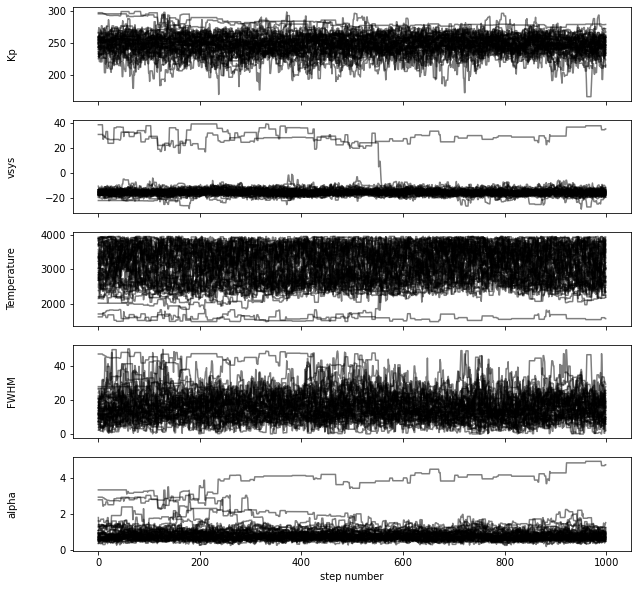

In [13]:
fig, axes = plt.subplots(5, figsize=(10, 10), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:,i], 'k',alpha=0.5)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [14]:


clean_labels = ['K_p', 'v_{rest}', 'T','FWHM', r'\alpha']
units = [' km/s',' km/s',' K',' km/s','']
title_fmt = ['.1f',".1f",".0f",".1f",".2f"]
titles = []
for i in range(5):
    med = np.median(samples[:,:,i])
    med = np.median(samples[:,:,i])
    q1 = np.quantile(samples[:,:,i], 0.16)
    q2 = np.quantile(samples[:,:,i], 0.84)
    fmt = "{{0:{0}}}".format(title_fmt[i]).format
    #title = r'{0} = {1:.2f}^{+{2:.2f}}'.format(clean_labels[i],med,q2-med)
    title = r"${0}={{{1}}}_{{-{2}}}^{{+{3}}}${4}".format(clean_labels[i], fmt(med),
                                                       fmt(med-q1),fmt(q2-med),units[i])
    #print(title)
    titles.append(title)
    #title = title.format(fmt(q_50), fmt(q_m), fmt(q_p))
    #print(title)
    print(labels[i], ': {0:.2f}  {1:.2f}  {2:.2f}'.format(med,q1-med, q2-med))
print(titles)

Kp : 250.09  -13.21  12.45
vsys : -15.17  -1.90  2.17
Temperature : 3144.95  -626.62  548.22
FWHM : 14.47  -5.80  7.79
alpha : 0.77  -0.19  0.32
['$K_p={250.1}_{-13.2}^{+12.4}$ km/s', '$v_{rest}={-15.2}_{-1.9}^{+2.2}$ km/s', '$T={3145}_{-627}^{+548}$ K', '$FWHM={14.5}_{-5.8}^{+7.8}$ km/s', '$\\alpha={0.77}_{-0.19}^{+0.32}$']


['$K_p={250.1}_{-13.2}^{+12.4}$ km/s', '$v_{rest}={-15.2}_{-1.9}^{+2.2}$ km/s', '$T={3145}_{-627}^{+548}$ K', '$FWHM={14.5}_{-5.8}^{+7.8}$ km/s', '$\\alpha={0.77}_{-0.19}^{+0.32}$']


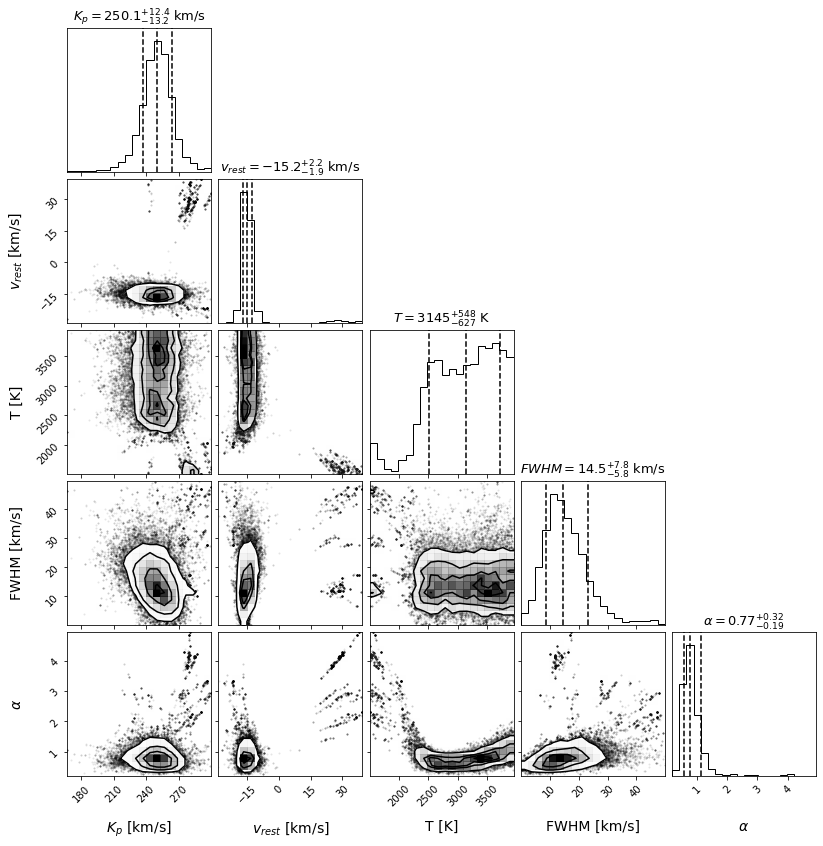

In [15]:
labels = [r'$K_p$ [km/s]', r'$v_{rest}$ [km/s]', 'T [K]','FWHM [km/s]', r'$\alpha$']
print(titles)
figure = corner.corner(samples.reshape(-1,5),labels=labels, label_kwargs={'fontsize':14},
              title_kwargs={'fontsize':13},titles=titles,show_titles=True,title_fmt=None, quantiles=[0.16, 0.5, 0.86])
axes = np.array(figure.axes).reshape((5,5))

